# 251. REINFORCE Algorithm

- Monte-Carlo method를 통해 구한 episodic sample 의 estimated return을 이용하여 policy parameter 𝜃를 update해 나가는 기법

- REINFORCE 갱신 규칙

$$\Delta\theta_t = \alpha\nabla_\theta\log{\pi_\theta}(s, a)G_t$$

- 따라서, Loss function 은
$$-G_t\log{\pi_\theta}(s, a)$$

```
                log_prob = torch.log(pi(state_tensor))
                selected_log_probs = reward_tensor * \
                        torch.gather(log_prob, 1, action_tensor.unsqueeze(1)).squeeze()
                loss = -1 * selected_log_probs.mean()
```

In [1]:
# swig 설치 (Box2D와 같은 C/C++ 확장 모듈 빌드 시 필요)
!apt-get install swig

# gymnasium 라이브러리 설치 (box2d 환경 지원 포함)
!pip install gymnasium[box2d]

# 비디오 녹화 기능에 필요한 X 가상 프레임버퍼(xvfb)와 X11 유틸리티 설치
# > tmp : 설치 로그를 tmp 파일로 리다이렉트
!apt-get install -y xvfb x11-utils > tmp

# 가상 디스플레이(pyvirtualdisplay) 설치 (버전 0.2.*로 고정)
# - Colab이나 서버 환경에서 GUI 없이 환경 렌더링/비디오 생성 가능
!pip install -q pyvirtualdisplay==0.2.*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [15]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import time
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


<img src="https://miro.medium.com/max/1400/1*4RncZNj1ij5A5eMJpexhrw.png" width=700/>

### 환경 초기화

In [19]:
ENV_NAME = 'CartPole-v1'
# ENV_NAME = 'LunarLander-v3'

# 환경 생성
env = gym.make(ENV_NAME)

# 행동 공간(Action space)을 정수 배열로 생성
# 예: 행동이 4개면 [0, 1, 2, 3]
action_space = np.arange(env.action_space.n)

# 행동 공간 출력
print(action_space)

# 관측 공간(Observation space)의 형태와 행동 개수 출력
# env.observation_space.shape: 관측 값의 차원
# env.action_space.n: 가능한 행동의 개수
print(env.observation_space.shape, env.action_space.n)

[0 1]
(4,) 2


### Policy Network 생성

In [20]:
# 차별 가능한(differentiable) 정책 파라미터화 pi(a|s, θ) 정의
class PolicyNetwork(nn.Module):
    def __init__(self, input_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        # 입력 차원(*input_dims) → 128개의 은닉 노드
        self.fc1 = nn.Linear(*input_dims, 128)

        # 128개의 은닉 노드 → 행동 개수(n_actions)
        self.fc2 = nn.Linear(128, n_actions)

    def forward(self, state):
        # 첫 번째 층 통과 후 ReLU 활성화 함수 적용
        x = F.relu(self.fc1(state))
        # 두 번째 층 통과 후 Softmax 적용 → 각 행동에 대한 확률 분포 생성
        prob = F.softmax(self.fc2(x), dim=-1)  # 마지막 차원을 기준으로 확률 계산
        return prob

# 파라미터 θ 초기화
# env.observation_space.shape : 관측 값의 차원 (예: (4,))
# env.action_space.n           : 행동의 개수 (예: 2)
pi = PolicyNetwork(
    input_dims=env.observation_space.shape,
    n_actions=env.action_space.n
).to(device)  # GPU 사용 가능 시 CUDA 디바이스에 로드

# 네트워크 구조 출력
pi

PolicyNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

### hyper-parameters 설정, reward 계산 도우미 함수 생성

In [21]:
# 학습률(스텝 사이즈) 설정: 0 < alpha < 1
alpha = 0.001

# 할인율(감가율) 설정: 0 < gamma < 1
gamma = 0.99

# 최대 학습 에피소드 수 N
N = 5_000

# 한 번의 업데이트에 사용할 에피소드 수 (배치 크기)
batch_size = 32

# Adam 최적화 알고리즘을 사용하여 정책 네트워크(pi) 학습
optimizer = optim.Adam(pi.parameters(), lr=alpha)

total_rewards = []  # 각 에피소드별 총 보상 저장 리스트

def discount_rewards(rewards):
    """
    주어진 보상 시퀀스를 할인율(gamma)을 적용하여 누적 보상(Return)으로 변환
    (마지막 보상부터 거꾸로 계산)
    """
    Returns = []    # 각 시점의 할인 보상 G_t 저장
    G = 0              # 누적 보상 초기값
    # 보상을 역순으로 순회하며 할인 보상 계산
    for r in rewards[::-1]:
        G = r + gamma * G      # G_t = r_t + γ * G_{t+1}
        Returns.append(G)

    # 계산된 리스트를 역순으로 뒤집어서 원래 시점 순서로 복원
    Returns = np.array(Returns[::-1], dtype=np.float64)

    # 보상 정규화 (평균 0, 표준편차 1로 스케일링) → 학습 안정성과 수렴 속도 개선
    Returns = (Returns - np.mean(Returns)) / (np.std(Returns) + 1e-8)

    return Returns

### main algorithm 작성 / Train

In [22]:
start_time = time.time()     # 학습 시작 시간 기록
batch_rewards = []            # 배치 내 모든 상태의 할인 보상 저장
batch_actions = []             # 배치 내 모든 상태에서의 행동 저장
batch_states = []              # 배치 내 모든 상태 저장
batch_counter = 0           # 배치 내 에피소드 개수 카운터

# While episode n < N do:
for episode in range(N):

    # 환경 초기화
    s, info = env.reset()

    # 현재 에피소드의 상태, 보상, 행동 저장용 리스트
    states, rewards, actions = [], [], []

    done = False
    # Generate an episode: s0, a0, r0, ... st, at, rt following policy pi(a|s, θ)
    while not done:
        # 정책 네트워크에서 행동 확률 분포 계산
        probs = pi(torch.as_tensor(s, dtype=torch.float32, device=device)) \
                    .detach().cpu().numpy()
        # 확률 분포에 따라 행동 샘플링
        a = np.random.choice(action_space, p=probs)

        # 환경에 행동 적용 → 다음 상태, 보상, 종료 여부 반환
        s_, r, terminated, truncated, info = env.step(int(a))
        done = terminated or truncated  # 종료 여부 판정

        # 현재 step의 경험 저장
        states.append(s)
        rewards.append(r)
        actions.append(a)

        # 상태 업데이트
        s = s_

        # 에피소드 종료 시 처리
        if done:
            # 1) 보상 시퀀스 → 할인 보상(Return)으로 변환
            batch_rewards.extend(discount_rewards(rewards))
            batch_states.extend(states)
            batch_actions.extend(actions)
            batch_counter += 1
            total_rewards.append(sum(rewards))  # 에피소드 총 보상 저장

            # 2) 배치 크기만큼 데이터가 쌓이면 정책 네트워크 업데이트
            if batch_counter == batch_size:
                # 상태, 보상, 행동 → 텐서 변환
                state_tensor = torch.FloatTensor(batch_states).to(device)
                reward_tensor = torch.FloatTensor(batch_rewards).to(device)
                action_tensor = torch.LongTensor(batch_actions).to(device)

                # 정책 로그 확률 계산
                log_prob = torch.log(pi(state_tensor))

                # 수행한 행동에 해당하는 로그 확률만 선택 후, 할인 보상 곱하기
                selected_log_probs = reward_tensor * \
                    torch.gather(log_prob, 1, action_tensor.unsqueeze(1)).squeeze()

                # 정책 경사도의 손실 함수: L(θ) = - 평균[ G_t * log π(a|s, θ) ]
                loss = -1 * selected_log_probs.mean()

                # 정책 네트워크 파라미터 업데이트
                optimizer.zero_grad()
                loss.backward()
                # 그래디언트 클리핑 (폭주 방지)
                torch.nn.utils.clip_grad_norm_(pi.parameters(), max_norm=1.0)
                optimizer.step()

                # 배치 데이터 초기화
                batch_rewards = []
                batch_actions = []
                batch_states = []
                batch_counter = 0  # 카운터 리셋

    # 100 에피소드마다 최근 100개 평균 보상 출력
    if episode % 100 == 0 and len(total_rewards) >= 100:
        avg_score = float(np.mean(total_rewards[-100:]))
        print(f'episode {episode},  최근 100 episode 평균 reward {avg_score: .2f}')

# 환경 종료
env.close()

episode 100,  최근 100 episode 평균 reward  25.47
episode 200,  최근 100 episode 평균 reward  27.61
episode 300,  최근 100 episode 평균 reward  29.45
episode 400,  최근 100 episode 평균 reward  32.09
episode 500,  최근 100 episode 평균 reward  31.89
episode 600,  최근 100 episode 평균 reward  38.69
episode 700,  최근 100 episode 평균 reward  36.08
episode 800,  최근 100 episode 평균 reward  43.63
episode 900,  최근 100 episode 평균 reward  42.87
episode 1000,  최근 100 episode 평균 reward  43.27
episode 1100,  최근 100 episode 평균 reward  42.20
episode 1200,  최근 100 episode 평균 reward  45.18
episode 1300,  최근 100 episode 평균 reward  49.03
episode 1400,  최근 100 episode 평균 reward  43.19
episode 1500,  최근 100 episode 평균 reward  49.72
episode 1600,  최근 100 episode 평균 reward  49.76
episode 1700,  최근 100 episode 평균 reward  57.79
episode 1800,  최근 100 episode 평균 reward  61.17
episode 1900,  최근 100 episode 평균 reward  58.70
episode 2000,  최근 100 episode 평균 reward  62.24
episode 2100,  최근 100 episode 평균 reward  72.01
episode 2200,  최근 100 

### reward 변화 시각화

duration =  3.598790717124939 minutes


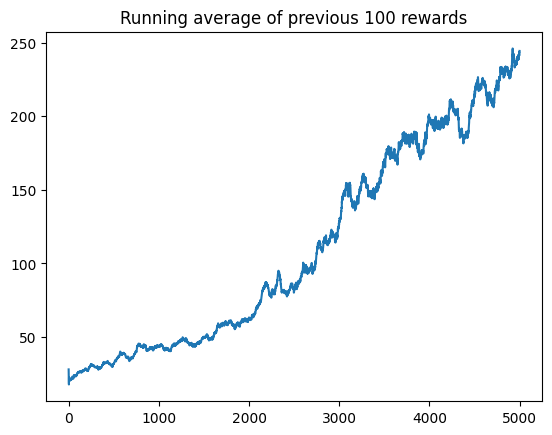

In [23]:
# 학습 소요 시간 출력 (분 단위)
print("duration = ", (time.time() - start_time) / 60, "minutes")

# 최근 100 에피소드 평균 보상을 저장할 배열 초기화
running_avg = np.zeros(len(total_rewards))

# 각 에피소드별 최근 100개 평균 보상 계산
for i in range(len(running_avg)):
    # i번째까지의 보상 중, 최대 100개 구간의 평균을 계산
    running_avg[i] = np.mean(total_rewards[max(0, i-100):(i+1)])

# 러닝 평균 보상 그래프 출력
plt.plot(running_avg)
plt.title('Running average of previous 100 rewards')  # 그래프 제목
plt.show()

### 이미 학습되어 저장된 model load

### Animate it with Video

In [24]:
from pyvirtualdisplay import Display
import glob
from IPython.display import HTML

# 동영상(mp4 등)을 base64로 인코딩하기 위한 모듈
from base64 import b64encode

# Gymnasium 환경에서 에피소드 실행 영상을 녹화하는 래퍼
from gymnasium.wrappers import RecordVideo

# 가상 디스플레이 시작 (Colab이나 서버 환경에서 영상 렌더링용)
display = Display(visible=0, size=(1400, 900))
display.start()

# MP4 영상을 HTML로 변환하여 노트북에 표시하는 함수
def render_mp4(videopath: str, width: int = 400) -> HTML:
    """
    지정된 경로(videopath)의 mp4 파일을 base64 인코딩하여
    HTML video 태그로 반환 (Jupyter/Colab에서 영상 재생 가능)
    """
    mp4 = open(videopath, 'rb').read()            # mp4 파일 읽기
    b64 = b64encode(mp4).decode('ascii')          # base64 인코딩
    return HTML(
        f'<video width="{width}" controls>'       # HTML video 태그 생성
        f'<source src="data:video/mp4;base64,{b64}" type="video/mp4"></video>'
    )

# 환경 준비
# render_mode='rgb_array'로 설정해야 RecordVideo가 동작 가능
env = gym.make(ENV_NAME, render_mode='rgb_array')

# 비디오 기록을 위한 래퍼(wrapper) 적용
# video_folder에 저장, episode_trigger=lambda e: True → 모든 에피소드 기록
env = RecordVideo(env, video_folder="videos", episode_trigger=lambda e: True)

# 행동(action) 공간 설정 (예: [0, 1])
action_space = np.arange(env.action_space.n)

# 에피소드 실행
state, info = env.reset()  # Gymnasium: reset() → (state, info) 반환
done = False
while not done:
    # 현재 상태(state)를 기반으로 정책 네트워크(pi)에서 행동 확률 계산
    with torch.no_grad():
        probs = pi(torch.as_tensor(state, dtype=torch.float32, device=device)) \
                    .detach().cpu().numpy()

    # 확률 분포(probs)에 따라 행동 선택
    a = int(np.random.choice(action_space, p=probs))

    # 환경에서 선택한 행동 실행
    next_state, reward, terminated, truncated, info = env.step(a)
    done = terminated or truncated      # 종료 조건 (목표 도달 or 시간 초과)

    # 상태 갱신
    state = next_state

# 환경 종료 (비디오 기록 완료)
env.close()

# 저장된 비디오 중 가장 최근 파일 찾기
latest_video = max(glob.glob(os.path.join("videos", "*.mp4")), key=os.path.getctime)

# Jupyter/Colab에서 비디오 재생
render_mp4(latest_video, width=600)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
